In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# 修改默认字体
font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal'}
plt.rc('font', **font)
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [3]:
# 定义全局变量
miu = 0.011
g = 9.8
m_ren=70
m_che=7
m = m_ren + m_che
r = 0.66   # 车轮半径
c = 0.25   # 一个未知系数
w_shoulder = 0.46    # 肩宽
l_leg = 1.0        # 腿长
s = w_shoulder * l_leg   # 人加车正对面积
rou = 1.205   # kg/m^3

sigma1 = 42 # 表示有氧呼吸的速率  # sigma2表示无氧呼吸的速率，以函数形式给出

W_max = 2403.5e3  # 最大的功率
alpha = 0.1   # 一个比率

In [4]:
# 阻力函数
def f1(theta):
    return math.cos(theta)*miu*m*g/(2*r) + m*g*math.sin(theta)

def f2(v):
    return 1/2*c*rou*s*v*v

def f_zu(theta, v):
    return f1(theta) + f2(v)

def sigma2(P):       # P是人体功率， v是当前速度
    if P < sigma1:
        return 0
    else:
        return P - sigma1 

# P功率最大维持时间
def T(P):
    return W_max / ( (2.38969595e-06*(P-sigma1)**3+3.2) *P)

# 添加k的时间
def T_new(P,k):
    return W_max / ( (2.38969595e-06*( (P-sigma1)/(1-k) )**3+3.2) *( (P-sigma1)/(1-k)+sigma1) )

# 要休息的时间
def T_rest(P):
    if P < 188:
        return 600 * 0.5
    else:
        return ((P-139)*(-9.76562500e-04*P + 1.18359375e+00))/97 * T(P) * 0.5


In [7]:
# 初始化挡位
dangwei=[]
dangwei_len=1000
for i in range(dangwei_len):
    dangwei.append(random.randint(1,7))


p_dw=[]
pp_temp=np.asarray([42,100,200,300,400,500,600,700])

p_dw_time = [17883, 600, 951, 181, 53, 20, 9, 5] 
p_dw_tr = [0, 1, 297, 120, 62, 43, 36, 34] 
p_dw_t_all = np.asarray(p_dw_time)  + np.asarray(p_dw_tr)

# p_dw矩阵初始化
for i in range(10):
    kkk = 0.1 * i
    p_dw.append( np.round((pp_temp-42)*(1-kkk) + 42,0) )
# print(p_dw)
v_dw=[
    [5.7,9.1,12.5,14.8,16.5,18.0,19.4,20.4],
    [5.7,8.8,12.1,14.2,15.9,17.4,18.6,19.7],
    [5.7,8.6,11.6,13.7,15.3,16.7,17.9,18.9],
    [5.7,8.3,11.1,13.1,14.6,15.9,17.1,18.1],
    [5.7,8.0,10.6,12.4,13.9,15.1,16.2,17.1],
    [5.7,7.7,10.0,11.7,13.0,14.2,15.2,16.1],
    [5.7,7.3,9.3,10.9,12.1,13.1,14.0,14.9],
    [5.7,6.9,8.6,9.9,11.0,11.9,12.7,13.5],
    [5.7,6.6,7.8,8.8,9.7,10.5,11.2,11.8],
    [5.7,6.1,6.8,6.8,7.5,8.6,9.0,9.5],
    [5.7,5.7,5.7,5.7,5.7,5.7,5.7,5.7]
]
v_a = v_dw
for kkk in range(0,10):
    kkk /= 10
    for i in range(1,8):
        v_a[int(kkk*10)][i] = (p_dw_time[i] * v_dw[int(kkk*10)][i] + 42 * 5.7) / (p_dw_time[i] + p_dw_tr[i])
# print(v_a)

p_bt_k = [2,2,4,5,5,6,6,7,7,7]  # k为0-0.9时的最佳挡位

# for i in range(len(v_a)):
#     plt.plot(v_a[i],label="k="+str(i/10 ))
#     print(v_a[i].index(max(v_a[i])))
# plt.legend()
# plt.show()

In [9]:
# 初始化转弯
turn=[[2000,5000],[7000,10000]]
v_limit=[6,5]

# 初始化坡度
slope = [0, 40, 80, 100, 110, 130, 140, 160, 195, 205, 215, 220, 234]
slope_angle = [0, 0.028025, 0, -0.062, 0, 0.095, -0.04735, 0, 0.0522, -0.0083, -0.088, 0]

theta_last = 0
theta_now = 0


times = 100000   # 尝试变换次数
t_all = [] # 记录每次中的到达终点需要的t
t_best = 30000

dw_best = dangwei.copy() #记录目前效果最好的dangwei数组
tem_alpha = 0.99
tem = 0.00000001       # 初始温度

for iii in range(times): # 尝试搜times次
    tem *= tem_alpha
    dangwei = dw_best.copy()   # 确认现在的挡位选择为当前最优
    #  确定dangwei_len
    dangwei_len=0
    time_all=0
    for jjj in range(1000):
        # print(jjj,time_all)
        time_all += p_dw_t_all[dangwei[jjj]]
        if time_all >= 20000:
            dangwei_len = jjj+1
            break


    # 随机出一个dangwei数组，长度500
    rrr = random.randint(1,dangwei_len-1)   # dangwei数组位置
    while True:
        rrrr = random.randint(1,7)              # 第rrr个位置换成 随机1-7之间的rrrr
        if dangwei[rrr]==rrrr:
            continue
        else:
            dangwei[rrr] = rrrr
            break

    # 初始化  目前不需要休息时间
    flag=1      #  判断结束后退出的标志
    j = 0  # 标志挡位改变的标记

    t=[]    # 时间
    v=[]    # 速度
    p=[]    # 功率
    x=[]    # 路程
    f=[]    # 阻力
    k=[]    # 记录取整的k
    E=[]    # 消耗的能量
    kk=[]   # 记录未取整的k
    sigma=[]

    # 添加初始值
    kk.append(0)
    t.append(0)
    v.append(0)
    k.append(0)
    p_new = p_dw[int(k[0]/0.1)][dangwei[j]]
    p.append(p_new)
    x.append(0)
    f.append(f1(0))

    ff=[]
    ff.append(f1(0))
    E.append(0)

    sigma.append(sigma2(p[0]))

    stay = p_dw_time[dangwei[j]]  # 该挡位可持续时间
    stay2= p_dw_t_all[dangwei[j]] # 加上所需42W休息时间

    # 开始迭代
    for i in range(1,100000):
        t_temp = t[i-1]+1;  t.append(t_temp)
        # 确定此时的P
        if i<=stay:
            p_temp = p_dw[int(k[i-1]/0.1)][dangwei[j]]
            # k_temp = (k[i-1]); k.append(k_temp//0.1 /10); 
            # kk.append(k_temp)
        elif i >stay and i < stay2:
            p_temp = sigma1
        elif i==stay2:
            p_temp = p_dw[int(k[i-1]/0.1)][dangwei[j+1]]
            p_new = p_dw[int(k[i-1]/0.1)][dangwei[j+1]]
            j+=1  # 下次取下一个挡位
            stay = stay2 + p_dw_time[dangwei[j]]
            stay2 = stay2 + p_dw_t_all[dangwei[j]]
            
        k_temp = (E[i-1] / 2e6); 
        if k_temp < 0.991:
            k.append(k_temp//0.1 /10); 
        else:
            k.append(0.99)

        p.append(p_temp)

        v_temp = math.sqrt( 2*(p[i-1]-f[i-1]*v[i-1])/m + v[i-1]**2 )
        x_temp = x[i-1] + (v[i-1] + v_temp)/2
        if len(turn)>0:
            if x_temp>=turn[0][1]:
                del turn[0]
                del v_limit[0]
            elif x_temp >= turn[0][0] and x_temp <turn[0][1]:
                v_temp = v_limit[0]
                x_temp = x_temp = x[i-1] + (v[i-1] + v_temp)/2

        v.append(v_temp)
        x.append(x_temp)
        if len(slope_angle)>0:
            if x_temp >= slope[0]*1e3:
                del slope[0]
                theta_last = math.atan(slope_angle[0])
                del slope_angle[0]
            theta_now = theta_last
        else:
            theta_now = 0
        

        f_temp = f_zu(theta_now,v[i]);    f.append(f_temp)
        ff_temp = f_zu(0,v[i]); ff.append(ff_temp)
        E_temp = E[i-1] + p[i-1] - sigma1;  E.append(E_temp)

        # print('时刻i: ', i, ' stay=',stay, ' t=',t[i],' p=',p[i],' v=',v[i],' x=',x[i],' f=',f[i],' E=',E[i],' k=',k[i])
        # if i%100 == 0:
        #     print('时刻i: ', i, ' stay=',stay, ' stay2=',stay2,' dw=',dangwei[j],' j=',j,' p=',p[i],' v=',v[i],' x=',format(x[i],'.1f'),' theta=',theta_now,'  f=',f_temp, 'k=',k[i])
        if x_temp>240000:
            t_all.append(i)
            if i < t_best:
                t_best = i
                dw_best = dangwei.copy()
            break
        else:
            p_simulated=math.exp(-abs(i-t_best)/tem)
            # print(abs(fsig_temp-fsig_last),p_simulated)
            if random.random()<p_simulated:
                t_best = i
                dw_best = dangwei.copy()

    if iii%100==0:
        print("第",iii,"次，  交换第",rrr,"个，  目前到达终点时间",t_all[iii]/3600,"，  最优时间",t_best/3600)

第 0 次，  交换第 10 个，  目前到达终点时间 14.121666666666666 ，  最优时间 8.333333333333334


In [21]:
# 打印结果
print(len(t_all),t_best,dw_best)


1000 28061 [2, 7, 1, 4, 3, 6, 2, 5, 1, 7, 3, 5, 3, 4, 2, 1, 5, 6, 7, 6, 2, 6, 7, 2, 4, 7, 5, 4, 7, 5, 7, 4, 3, 4, 6, 2, 5, 6, 4, 5, 3, 4, 3, 7, 4, 4, 3, 4, 5, 7, 3, 6, 1, 5, 4, 7, 2, 6, 7, 5, 1, 1, 4, 6, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

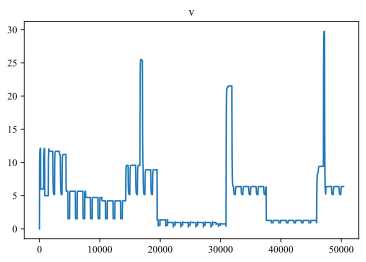

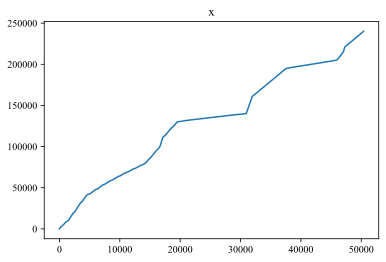

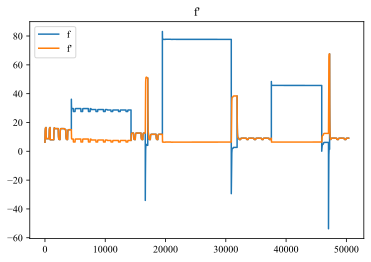

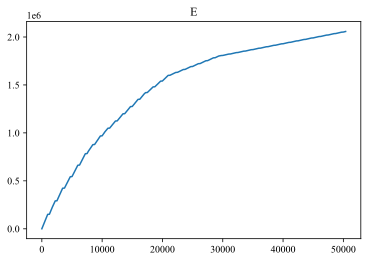

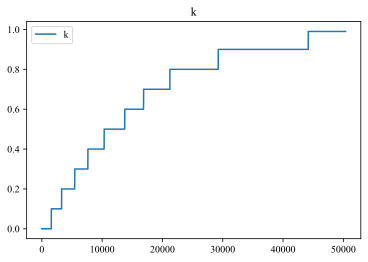

In [15]:
# 绘图

plt.plot(t,v)
plt.title("v")
plt.show()

plt.plot(t,x)
plt.title("x")
plt.show()

plt.plot(t,f,label="f")
plt.plot(t,ff,label="f'")
plt.title("f")
plt.title("f'")
plt.legend()
plt.show()

plt.plot(t,E)
plt.title("E")
plt.show()

plt.plot(t,k,label='k')
# plt.plot(t,kk,label="k'")

plt.title("k")
plt.legend()
plt.show()
